In [1238]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import datetime, timedelta
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import FuncFormatter
import psutil
import mplfinance as mpf
import matplotlib.dates as mdates
import warnings

Scrape Taiwan Bank FX Rates

In [1239]:
#USDTWD Spot data
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
     "dataset": "TaiwanExchangeRate",
     "data_id": "USD",
     "start_date": "2024-01-01",
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data['spot_rate'] = (data['spot_buy'] + data['spot_sell']) / 2

USDTWD_spot = data[['date', 'spot_rate']]

In [1240]:
#USDJPY Spot data
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
     "dataset": "TaiwanExchangeRate",
     "data_id": "JPY",
     "start_date": "2024-01-01",
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data['spot_rate'] = (data['spot_buy'] + data['spot_sell']) / 2

JPYTWD_Spot = data[['date', 'spot_rate']]
merged_df = pd.merge(USDTWD_spot, JPYTWD_Spot, on='date', suffixes=('_usdtwd', '_jpytwd'))
merged_df['spot_rate'] = merged_df['spot_rate_usdtwd'] / merged_df['spot_rate_jpytwd']
USDJPY_spot = merged_df[['date', 'spot_rate']]

In [1241]:
#USDCNH Spot data
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
     "dataset": "TaiwanExchangeRate",
     "data_id": "CNY",
     "start_date": "2024-01-01",
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data['spot_rate'] = (data['spot_buy'] + data['spot_sell']) / 2

CNYTWD_Spot = data[['date', 'spot_rate']]
merged_df = pd.merge(USDTWD_spot, CNYTWD_Spot, on='date', suffixes=('_usdtwd', '_cnytwd'))
merged_df['spot_rate'] = merged_df['spot_rate_usdtwd'] / merged_df['spot_rate_cnytwd']
USDCNH_spot = merged_df[['date', 'spot_rate']]

In [1242]:
#EURUSD Spot data
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
     "dataset": "TaiwanExchangeRate",
     "data_id": "EUR",
     "start_date": "2024-01-01",
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
data['spot_rate'] = (data['spot_buy'] + data['spot_sell']) / 2

EURTWD_Spot = data[['date', 'spot_rate']]
merged_df = pd.merge(USDTWD_spot, EURTWD_Spot, on='date', suffixes=('_usdtwd', '_eurtwd'))
merged_df['spot_rate'] = merged_df['spot_rate_eurtwd'] / merged_df['spot_rate_usdtwd']
EURUSD_spot = merged_df[['date', 'spot_rate']]

In [1243]:
absolute_path = '/Users/jonathancheng/Library/Mobile Documents/com~apple~CloudDocs/Cathay/相匯自動化/option_dashboard/opt 20240426.xlsx'
excel_data = pd.read_excel(absolute_path, sheet_name=None)
excel_data = pd.DataFrame(excel_data['FT Data'])

#data cleaning
selected_columns = ['Trade Type', 'Customer', 'cCUST_LegalName', 'Trade entry', 'FX value date', 'Strike', 'P or S', 'Put/Call', 'Notional', 'cPREMDATA_Prem', 'Currency pair']
opt_data = excel_data.loc[:, selected_columns]
#input CCY
opt_data['P or S'] = opt_data['P or S'].replace({'P': 'Sell', 'C': 'Buy'})
opt_data['Put/Call'] = opt_data['Put/Call'].replace({'P': 'Put', 'C': 'Call'})

#set up delivery date
opt_data['Delivery DF'] = (pd.to_datetime(opt_data['FX value date']) - pd.to_datetime(opt_data['Trade entry'])).dt.days

#divide Call/Put data
opt_data_call = opt_data[opt_data['Put/Call'] == 'Call']
opt_data_put = opt_data[opt_data['Put/Call'] == 'Put']

Remaining Days to Option Expiration

In [1244]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Your code with DataFrame operations
    today = datetime.today()

    opt_data_call["FX value date"] = pd.to_datetime(opt_data_call["FX value date"])
    opt_data_put["FX value date"] = pd.to_datetime(opt_data_put["FX value date"])
    opt_data_call["Trade entry"] = pd.to_datetime(opt_data_call["Trade entry"])
    opt_data_put["Trade entry"] = pd.to_datetime(opt_data_put["Trade entry"])

    opt_data_call_due = opt_data_call[opt_data_call["FX value date"] < today]
    opt_data_call_less_3months = opt_data_call[(opt_data_call["FX value date"] >= today) & (opt_data_call["FX value date"] <= today + timedelta(days=90))]
    opt_data_call_more_3months = opt_data_call[opt_data_call["FX value date"] > today + timedelta(days=90)]

    opt_data_put_due = opt_data_put[opt_data_put["FX value date"] < today]
    opt_data_put_less_3months = opt_data_put[(opt_data_put["FX value date"] >= today) & (opt_data_put["FX value date"] <= today + timedelta(days=90))]
    opt_data_put_more_3months = opt_data_put[opt_data_put["FX value date"] > today + timedelta(days=90)]

Seperate CCY

In [1245]:
#USDTWD
USDTWD_opt_data_call = opt_data_call[opt_data_call['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_put = opt_data_put[opt_data_put['Currency pair'] == 'USD/TWD']

USDTWD_opt_data_call_due = opt_data_call_due[opt_data_call_due['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_put_due = opt_data_put_due[opt_data_put_due['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_call_less_3months = opt_data_call_less_3months[opt_data_call_less_3months['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_put_less_3months = opt_data_put_less_3months[opt_data_put_less_3months['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_call_more_3months = opt_data_call_more_3months[opt_data_call_more_3months['Currency pair'] == 'USD/TWD']
USDTWD_opt_data_put_more_3months = opt_data_put_more_3months[opt_data_put_more_3months['Currency pair'] == 'USD/TWD']

#USDJPY
USDJPY_opt_data_call = opt_data_call[opt_data_call['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_put = opt_data_put[opt_data_put['Currency pair'] == 'USD/JPY']

USDJPY_opt_data_call_due = opt_data_call_due[opt_data_call_due['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_put_due = opt_data_put_due[opt_data_put_due['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_call_less_3months = opt_data_call_less_3months[opt_data_call_less_3months['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_put_less_3months = opt_data_put_less_3months[opt_data_put_less_3months['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_call_more_3months = opt_data_call_more_3months[opt_data_call_more_3months['Currency pair'] == 'USD/JPY']
USDJPY_opt_data_put_more_3months = opt_data_put_more_3months[opt_data_put_more_3months['Currency pair'] == 'USD/JPY']

#EURUSD
EURUSD_opt_data_call = opt_data_call[opt_data_call['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_put = opt_data_put[opt_data_put['Currency pair'] == 'EUR/USD']

EURUSD_opt_data_call_due = opt_data_call_due[opt_data_call_due['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_put_due = opt_data_put_due[opt_data_put_due['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_call_less_3months = opt_data_call_less_3months[opt_data_call_less_3months['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_put_less_3months = opt_data_put_less_3months[opt_data_put_less_3months['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_call_more_3months = opt_data_call_more_3months[opt_data_call_more_3months['Currency pair'] == 'EUR/USD']
EURUSD_opt_data_put_more_3months = opt_data_put_more_3months[opt_data_put_more_3months['Currency pair'] == 'EUR/USD']

#USDCNH
USDCNH_opt_data_call = opt_data_call[opt_data_call['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_put = opt_data_put[opt_data_put['Currency pair'] == 'USD/CNH']

USDCNH_opt_data_call_due = opt_data_call_due[opt_data_call_due['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_put_due = opt_data_put_due[opt_data_put_due['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_call_less_3months = opt_data_call_less_3months[opt_data_call_less_3months['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_put_less_3months = opt_data_put_less_3months[opt_data_put_less_3months['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_call_more_3months = opt_data_call_more_3months[opt_data_call_more_3months['Currency pair'] == 'USD/CNH']
USDCNH_opt_data_put_more_3months = opt_data_put_more_3months[opt_data_put_more_3months['Currency pair'] == 'USD/CNH']


1.USDTWD

In [1246]:
# Calculate option P&L
USDTWD_opt_data_call_data = USDTWD_spot.copy()  # 修改變數名稱
PL_list = []

# Loop through each date in USDTWD_spot
for _, row in USDTWD_opt_data_call_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    # Filter options that are active on the current_date
    active_options = USDTWD_opt_data_call[  # 修改選擇權資料框名稱
        (USDTWD_opt_data_call['Trade entry'] <= current_date) &
        (USDTWD_opt_data_call['FX value date'] >= current_date)
    ]

    # Calculate P&L for each active option
    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (strike - spot_rate) * (notional * spot_rate) / spot_rate

    # Append the calculated P&L to the list
    PL_list.append(PL)

# Create a new DataFrame
USDTWD_spot_call = USDTWD_spot.copy()  # 修改資料框名稱
USDTWD_spot_call['P&L'] = PL_list


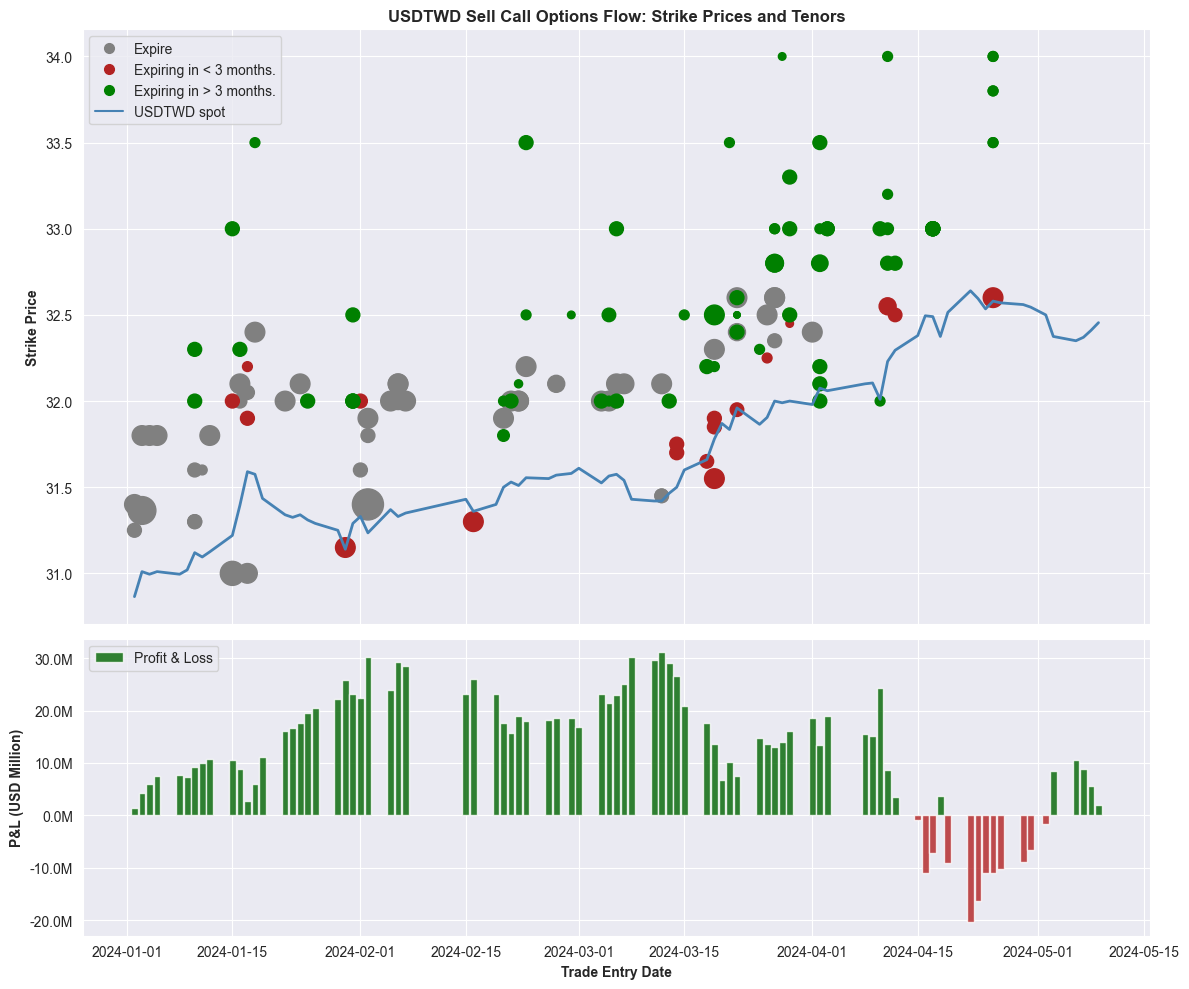

In [1247]:
# Ensure that the date column is converted to datetime and set it as index
USDTWD_spot['date'] = pd.to_datetime(USDTWD_spot['date'])
USDTWD_spot.set_index('date', inplace=True)

# Convert the date column to datetime for USDTWD_spot_call if not already done
USDTWD_spot_call['date'] = pd.to_datetime(USDTWD_spot_call['date'])

# Create subplots with different heights for ax1 and ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

sns.set_style("darkgrid")

# Plot the USDTWD spot rate on ax1
ax1.plot(USDTWD_spot.index, USDTWD_spot['spot_rate'], color='steelblue', linewidth=2, label='USDTWD spot')

plot_size = 0.0001

# Scatter plots for different option data with varying marker sizes on ax1
ax1.scatter(USDTWD_opt_data_call_due["Trade entry"], USDTWD_opt_data_call_due["Strike"], 
            s=USDTWD_opt_data_call_due["Notional"] * plot_size, c='grey', label='Expire')
ax1.scatter(USDTWD_opt_data_call_less_3months["Trade entry"], USDTWD_opt_data_call_less_3months["Strike"], 
            s=USDTWD_opt_data_call_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')
ax1.scatter(USDTWD_opt_data_call_more_3months["Trade entry"], USDTWD_opt_data_call_more_3months["Strike"], 
            s=USDTWD_opt_data_call_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')

# Labels and titles for ax1
ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDTWD Sell Call Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")
ax1.grid(True)

# Set up the legend for ax1
handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7  # Adjust the size to your preference
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  # 新增一個藍色折線圖例
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDTWD spot'],  # 新增"USDTWD spot"文字
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDTWD_spot_call['P&L']]

# Plot the bar chart for Profit & Loss on ax2 using USDTWD_spot_call's date
ax2.bar(USDTWD_spot_call['date'], USDTWD_spot_call['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))  # Set y-axis ticks formatter to millions
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

# Adjust the right y-axis scale for ax2
right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])

# Add a legend to the second subplot
ax2.legend(loc='upper left')

# Adjust layout for clarity
fig.tight_layout()
plt.show()


In [1248]:
# Calculate option P&L
USDTWD_opt_data_put_data = USDTWD_spot.copy()
USDTWD_opt_data_put_data = USDTWD_spot.copy().reset_index()
PL_list = []

for _, row in USDTWD_opt_data_put_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    active_options = USDTWD_opt_data_put[
        (USDTWD_opt_data_put['Trade entry'] <= current_date) &
        (USDTWD_opt_data_put['FX value date'] >= current_date)
    ]

    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (spot_rate - strike) * (notional * spot_rate) / spot_rate

    PL_list.append(PL)

USDTWD_spot_put = USDTWD_spot.copy()
USDTWD_spot_put['P&L'] = PL_list
USDTWD_spot_put = USDTWD_spot_put.copy().reset_index()


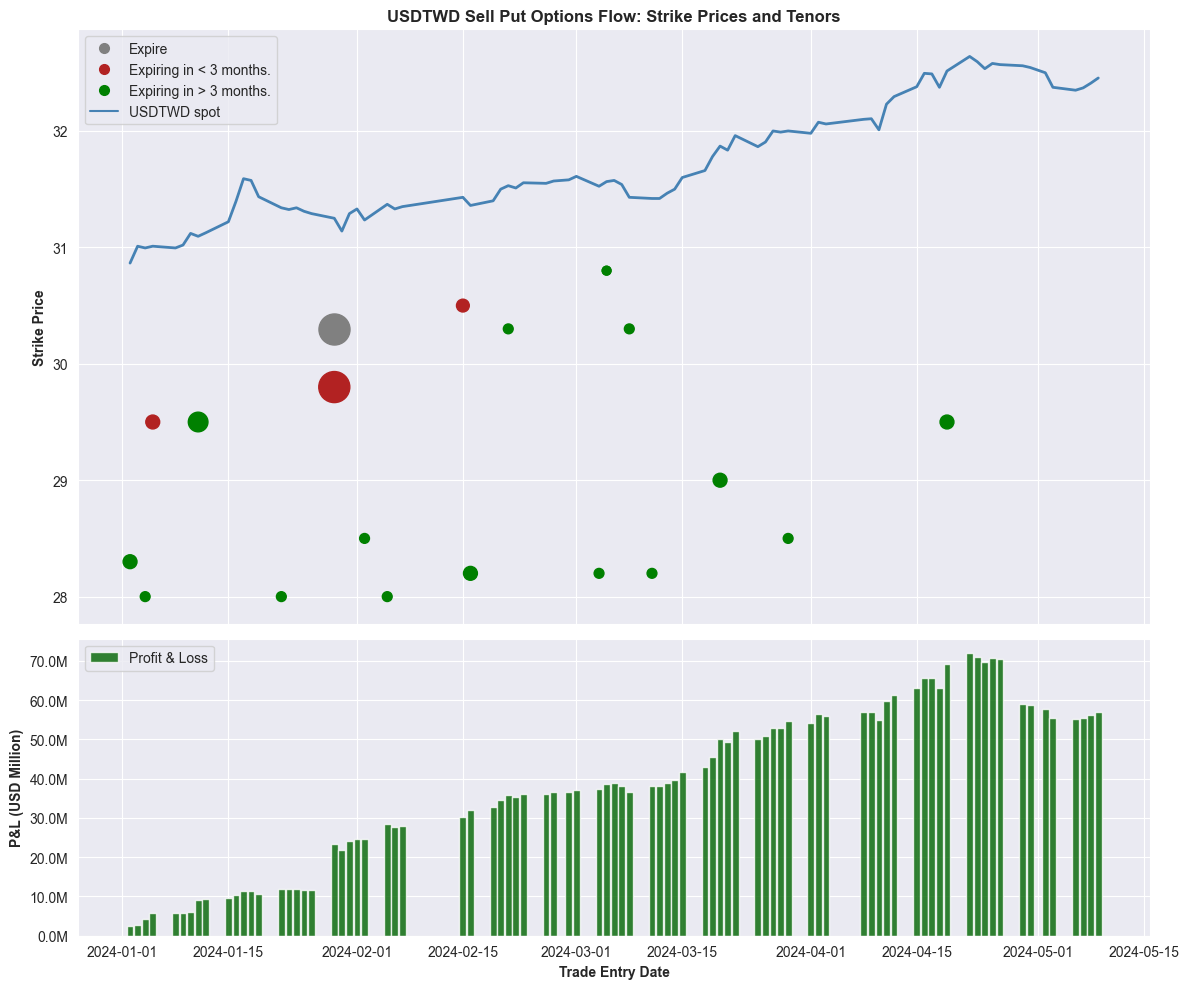

In [1249]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
sns.set_style("darkgrid")
ax1.plot(USDTWD_spot.index, USDTWD_spot['spot_rate'], color='steelblue', linewidth=2, label='USDTWD spot')  # 修改為 USDTWD_spot
plot_size = 0.0001
ax1.scatter(USDTWD_opt_data_put_due["Trade entry"], USDTWD_opt_data_put_due["Strike"], 
            s=USDTWD_opt_data_put_due["Notional"] * plot_size, c='grey', label='Expire')  # 修改為 USDTWD_opt_data_put_due
ax1.scatter(USDTWD_opt_data_put_less_3months["Trade entry"], USDTWD_opt_data_put_less_3months["Strike"], 
            s=USDTWD_opt_data_put_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')  # 修改為 USDTWD_opt_data_put_less_3months
ax1.scatter(USDTWD_opt_data_put_more_3months["Trade entry"], USDTWD_opt_data_put_more_3months["Strike"], 
            s=USDTWD_opt_data_put_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')  # 修改為 USDTWD_opt_data_put_more_3months
ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDTWD Sell Put Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")  # 修改標題
ax1.grid(True)

handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7 
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDTWD spot'],  # 修改為 USDTWD spot
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDTWD_spot_put['P&L']]  # 修改為 USDTWD_spot_put

ax2.bar(USDTWD_spot_put['date'], USDTWD_spot_put['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')  # 修改為 USDTWD_spot_put
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M')) 
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])
ax2.legend(loc='upper left')
fig.tight_layout()
plt.show()


2.USDJPY

In [1250]:
#calculate option P&L
USDJPY_opt_data_call_data = USDJPY_spot.copy()
# Initialize a list to hold P&L values
PL_list = []

# Loop through each date in USDJPY_spot
for _, row in USDJPY_opt_data_call_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    # Filter options that are active on the current_date
    active_options = USDJPY_opt_data_call[
        (USDJPY_opt_data_call['Trade entry'] <= current_date) &
        (USDJPY_opt_data_call['FX value date'] >= current_date)
    ]

    # Calculate P&L for each active option
    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (strike - spot_rate) * (notional * spot_rate) / spot_rate

    # Append the calculated P&L to the list
    PL_list.append(PL)

# Create a new DataFrame
USDJPY_spot_call = USDJPY_spot.copy()
USDJPY_spot_call['P&L'] = PL_list

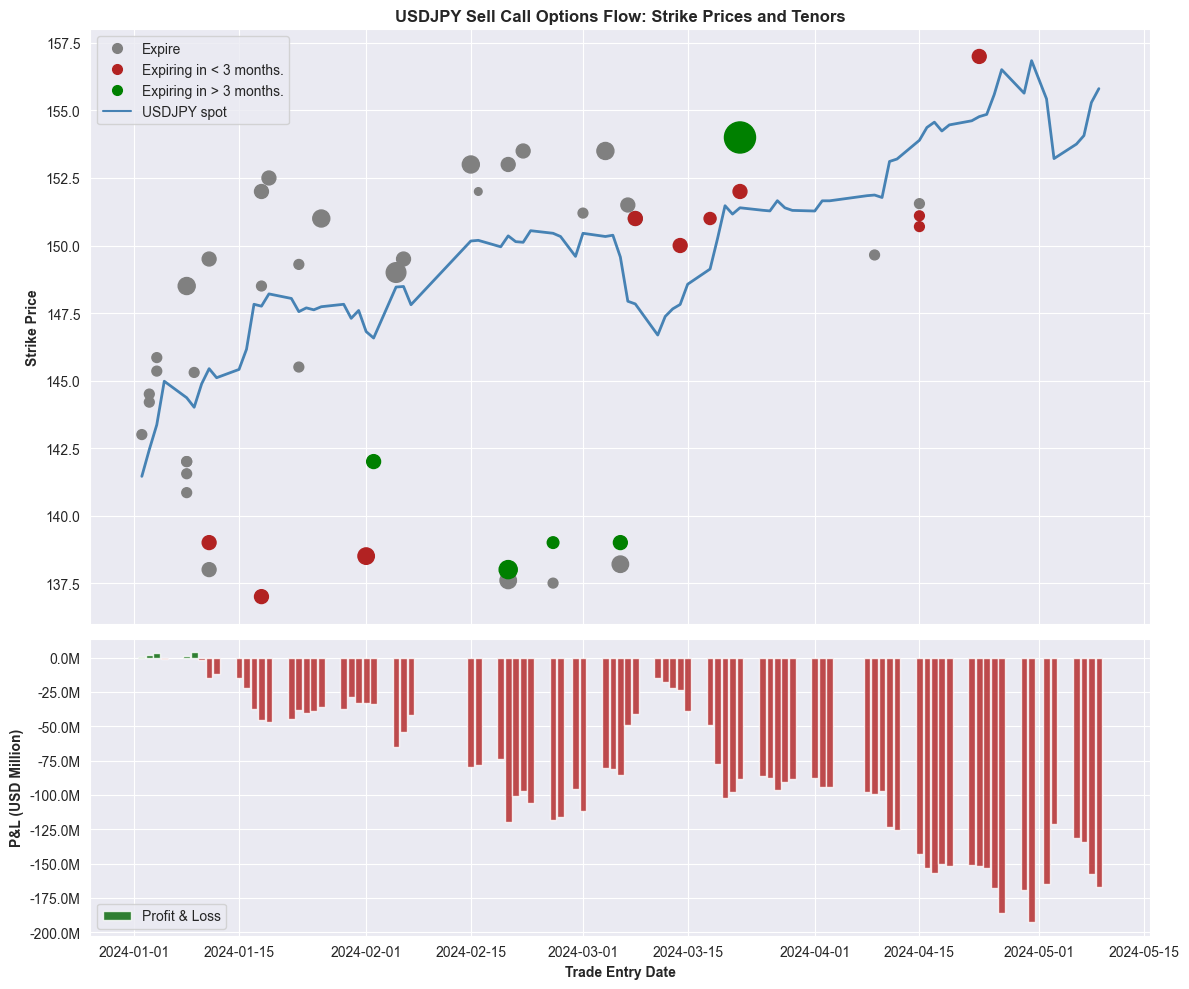

In [1251]:
# Ensure that the date column is converted to datetime and set it as index
USDJPY_spot['date'] = pd.to_datetime(USDJPY_spot['date'])
USDJPY_spot.set_index('date', inplace=True)

# Convert the date column to datetime for USDJPY_spot_call if not already done
USDJPY_spot_call['date'] = pd.to_datetime(USDJPY_spot_call['date'])

# Create subplots with different heights for ax1 and ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

sns.set_style("darkgrid")

# Plot the USDJPY spot rate on ax1
ax1.plot(USDJPY_spot.index, USDJPY_spot['spot_rate'], color='steelblue', linewidth=2, label='USDJPY spot')

plot_size = 0.0001

# Scatter plots for different option data with varying marker sizes on ax1
ax1.scatter(USDJPY_opt_data_call_due["Trade entry"], USDJPY_opt_data_call_due["Strike"], 
            s=USDJPY_opt_data_call_due["Notional"] * plot_size, c='grey', label='Expire')
ax1.scatter(USDJPY_opt_data_call_less_3months["Trade entry"], USDJPY_opt_data_call_less_3months["Strike"], 
            s=USDJPY_opt_data_call_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')
ax1.scatter(USDJPY_opt_data_call_more_3months["Trade entry"], USDJPY_opt_data_call_more_3months["Strike"], 
            s=USDJPY_opt_data_call_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')

# Labels and titles for ax1
ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDJPY Sell Call Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")
ax1.grid(True)

# Set up the legend for ax1
handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7  # Adjust the size to your preference
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  # 新增一個藍色折線圖例
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDJPY spot'],  # 新增"USDJPY spot"文字
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDJPY_spot_call['P&L']]

# Plot the bar chart for Profit & Loss on ax2 using USDJPY_spot_call's date
ax2.bar(USDJPY_spot_call['date'], USDJPY_spot_call['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))  # Set y-axis ticks formatter to millions
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

# Adjust the right y-axis scale for ax2
right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])

# Add a legend to the second subplot
ax2.legend(loc='lower left')

# Adjust layout for clarity
fig.tight_layout()
plt.show()

In [1252]:
# Calculate option P&L
USDJPY_opt_data_put_data = USDJPY_spot.copy()
USDJPY_opt_data_put_data = USDJPY_spot.copy().reset_index()
PL_list = []

for _, row in USDJPY_opt_data_put_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    active_options = USDJPY_opt_data_put[
        (USDJPY_opt_data_put['Trade entry'] <= current_date) &
        (USDJPY_opt_data_put['FX value date'] >= current_date)
    ]

    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (spot_rate - strike) * (notional * spot_rate) / spot_rate

    PL_list.append(PL)

USDJPY_spot_put = USDJPY_spot.copy()
USDJPY_spot_put['P&L'] = PL_list
USDJPY_spot_put = USDJPY_spot_put.copy().reset_index()

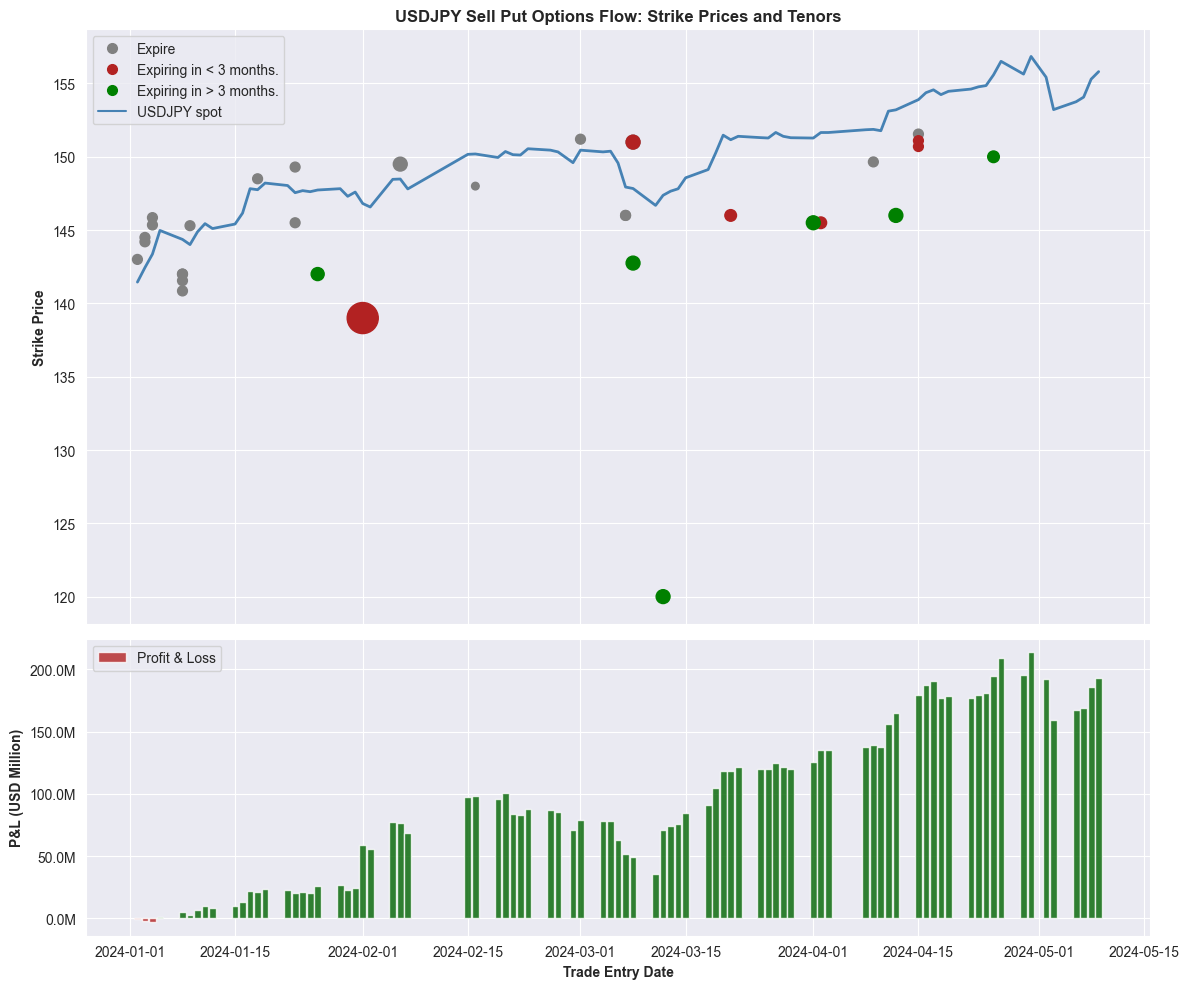

In [1253]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
sns.set_style("darkgrid")
ax1.plot(USDJPY_spot.index, USDJPY_spot['spot_rate'], color='steelblue', linewidth=2, label='USDJPY spot')

plot_size = 0.0001
ax1.scatter(USDJPY_opt_data_put_due["Trade entry"], USDJPY_opt_data_put_due["Strike"], 
            s=USDJPY_opt_data_put_due["Notional"] * plot_size, c='grey', label='Expire')  # 修改為 put 選擇權相關的資料框
ax1.scatter(USDJPY_opt_data_put_less_3months["Trade entry"], USDJPY_opt_data_put_less_3months["Strike"], 
            s=USDJPY_opt_data_put_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')  # 修改為 put 選擇權相關的資料框
ax1.scatter(USDJPY_opt_data_put_more_3months["Trade entry"], USDJPY_opt_data_put_more_3months["Strike"], 
            s=USDJPY_opt_data_put_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')  # 修改為 put 選擇權相關的資料框

ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDJPY Sell Put Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")  # 修改標題
ax1.grid(True)

handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7 
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDJPY spot'],  
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDJPY_spot_put['P&L']]  # 修改為 put 選擇權相關的資料框

ax2.bar(USDJPY_spot_put['date'], USDJPY_spot_put['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M')) 
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])
ax2.legend(loc='upper left')
fig.tight_layout()
plt.show()


3.EURUSD

In [1254]:
# Calculate option P&L
EURUSD_opt_data_call_data = EURUSD_spot.copy()
# Initialize a list to hold P&L values
PL_list = []

# Loop through each date in EURUSD_spot
for _, row in EURUSD_opt_data_call_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    # Filter options that are active on the current_date
    active_options = EURUSD_opt_data_call[
        (EURUSD_opt_data_call['Trade entry'] <= current_date) &
        (EURUSD_opt_data_call['FX value date'] >= current_date)
    ]

    # Calculate P&L for each active option
    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (strike - spot_rate) * (notional * spot_rate) / spot_rate

    # Append the calculated P&L to the list
    PL_list.append(PL)

# Create a new DataFrame
EURUSD_spot_call = EURUSD_spot.copy()
EURUSD_spot_call['P&L'] = PL_list


/var/folders/__/xzj5zz3513g83k8y3ljp040m0000gn/T/ipykernel_66637/2521499102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EURUSD_spot['date'] = pd.to_datetime(EURUSD_spot['date'])


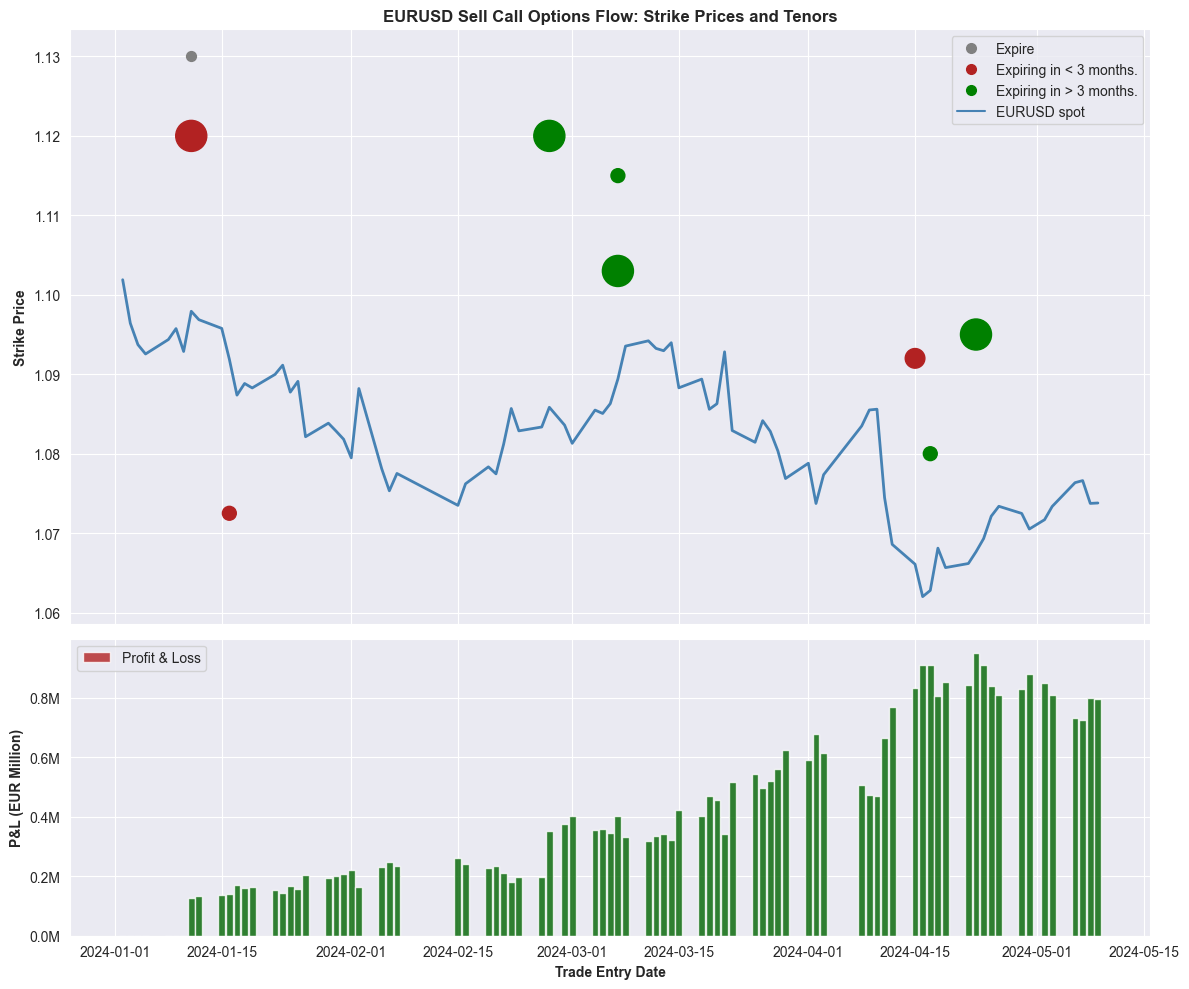

In [1255]:
# Ensure that the date column is converted to datetime and set it as index
EURUSD_spot['date'] = pd.to_datetime(EURUSD_spot['date'])
EURUSD_spot.set_index('date', inplace=True)

# Convert the date column to datetime for EURUSD_spot_call if not already done
EURUSD_spot_call['date'] = pd.to_datetime(EURUSD_spot_call['date'])

# Create subplots with different heights for ax1 and ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

sns.set_style("darkgrid")

# Plot the EURUSD spot rate on ax1
ax1.plot(EURUSD_spot.index, EURUSD_spot['spot_rate'], color='steelblue', linewidth=2, label='EURUSD spot')

plot_size = 0.0001

# Scatter plots for different option data with varying marker sizes on ax1
ax1.scatter(EURUSD_opt_data_call_due["Trade entry"], EURUSD_opt_data_call_due["Strike"], 
            s=EURUSD_opt_data_call_due["Notional"] * plot_size, c='grey', label='Expire')
ax1.scatter(EURUSD_opt_data_call_less_3months["Trade entry"], EURUSD_opt_data_call_less_3months["Strike"], 
            s=EURUSD_opt_data_call_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')
ax1.scatter(EURUSD_opt_data_call_more_3months["Trade entry"], EURUSD_opt_data_call_more_3months["Strike"], 
            s=EURUSD_opt_data_call_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')

# Labels and titles for ax1
ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('EURUSD Sell Call Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")
ax1.grid(True)

# Set up the legend for ax1
handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7  # Adjust the size to your preference
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  # 新增一個藍色折線圖例
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'EURUSD spot'],  # 新增"EURUSD spot"文字
           loc='upper right')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in EURUSD_spot_call['P&L']]

# Plot the bar chart for Profit & Loss on ax2 using EURUSD_spot_call's date
ax2.bar(EURUSD_spot_call['date'], EURUSD_spot_call['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))  # Set y-axis ticks formatter to millions
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (EUR Million)', fontweight="bold")
ax2.grid(True)

# Adjust the right y-axis scale for ax2
right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])

# Add a legend to the second subplot
ax2.legend(loc='upper left')

# Adjust layout for clarity
fig.tight_layout()
plt.show()


In [1256]:
# Calculate option P&L
EURUSD_opt_data_put_data = EURUSD_spot.copy()
EURUSD_opt_data_put_data = EURUSD_spot.copy().reset_index()
PL_list = []

for _, row in EURUSD_opt_data_put_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    active_options = EURUSD_opt_data_put[
        (EURUSD_opt_data_put['Trade entry'] <= current_date) &
        (EURUSD_opt_data_put['FX value date'] >= current_date)
    ]

    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (spot_rate - strike) * (notional * spot_rate) / spot_rate

    PL_list.append(PL)

EURUSD_spot_put = EURUSD_spot.copy()
EURUSD_spot_put['P&L'] = PL_list
EURUSD_spot_put = EURUSD_spot_put.copy().reset_index()


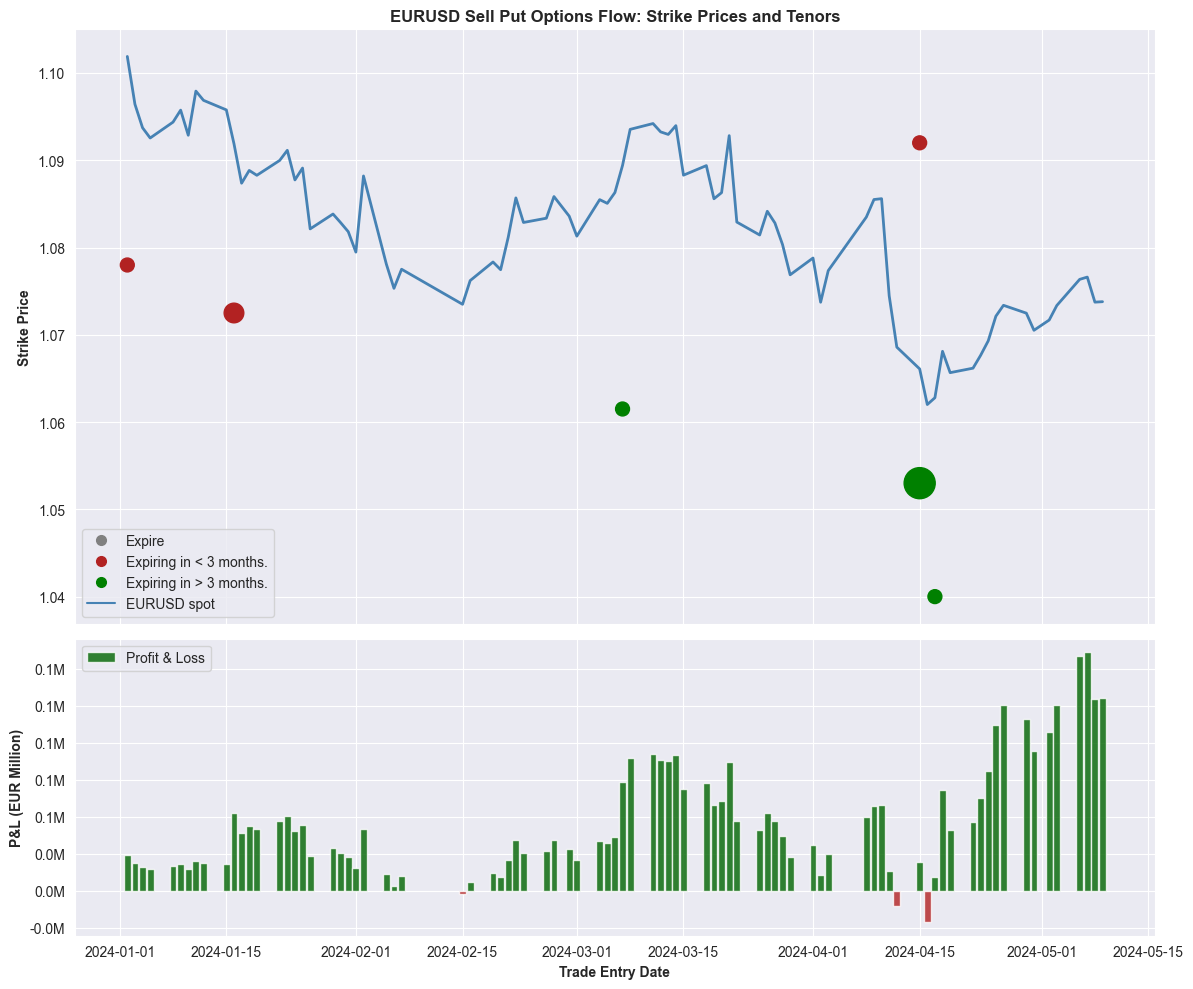

In [1257]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
sns.set_style("darkgrid")
ax1.plot(EURUSD_spot.index, EURUSD_spot['spot_rate'], color='steelblue', linewidth=2, label='EURUSD spot')

plot_size = 0.0001
ax1.scatter(EURUSD_opt_data_put_due["Trade entry"], EURUSD_opt_data_put_due["Strike"], 
            s=EURUSD_opt_data_put_due["Notional"] * plot_size, c='grey', label='Expire')  # 修改為 put 選擇權相關的資料框
ax1.scatter(EURUSD_opt_data_put_less_3months["Trade entry"], EURUSD_opt_data_put_less_3months["Strike"], 
            s=EURUSD_opt_data_put_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')  # 修改為 put 選擇權相關的資料框
ax1.scatter(EURUSD_opt_data_put_more_3months["Trade entry"], EURUSD_opt_data_put_more_3months["Strike"], 
            s=EURUSD_opt_data_put_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')  # 修改為 put 選擇權相關的資料框

ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('EURUSD Sell Put Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")  # 修改標題
ax1.grid(True)

handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7 
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'EURUSD spot'],  
           loc='lower left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in EURUSD_spot_put['P&L']]  # 修改為 put 選擇權相關的資料框

ax2.bar(EURUSD_spot_put['date'], EURUSD_spot_put['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M')) 
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (EUR Million)', fontweight="bold")
ax2.grid(True)

right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])
ax2.legend(loc='upper left')
fig.tight_layout()
plt.show()


4.USDCNH

In [1258]:
USDCNH_opt_data_call_data = USDCNH_spot.copy()
# Initialize a list to hold P&L values
PL_list = []

# Loop through each date in USDCNH_spot
for _, row in USDCNH_opt_data_call_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    # Filter options that are active on the current_date
    active_options = USDCNH_opt_data_call[
        (USDCNH_opt_data_call['Trade entry'] <= current_date) &
        (USDCNH_opt_data_call['FX value date'] >= current_date)
    ]

    # Calculate P&L for each active option
    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (strike - spot_rate) * (notional * spot_rate) / spot_rate

    # Append the calculated P&L to the list
    PL_list.append(PL)

# Create a new DataFrame
USDCNH_spot_call = USDCNH_spot.copy()
USDCNH_spot_call['P&L'] = PL_list


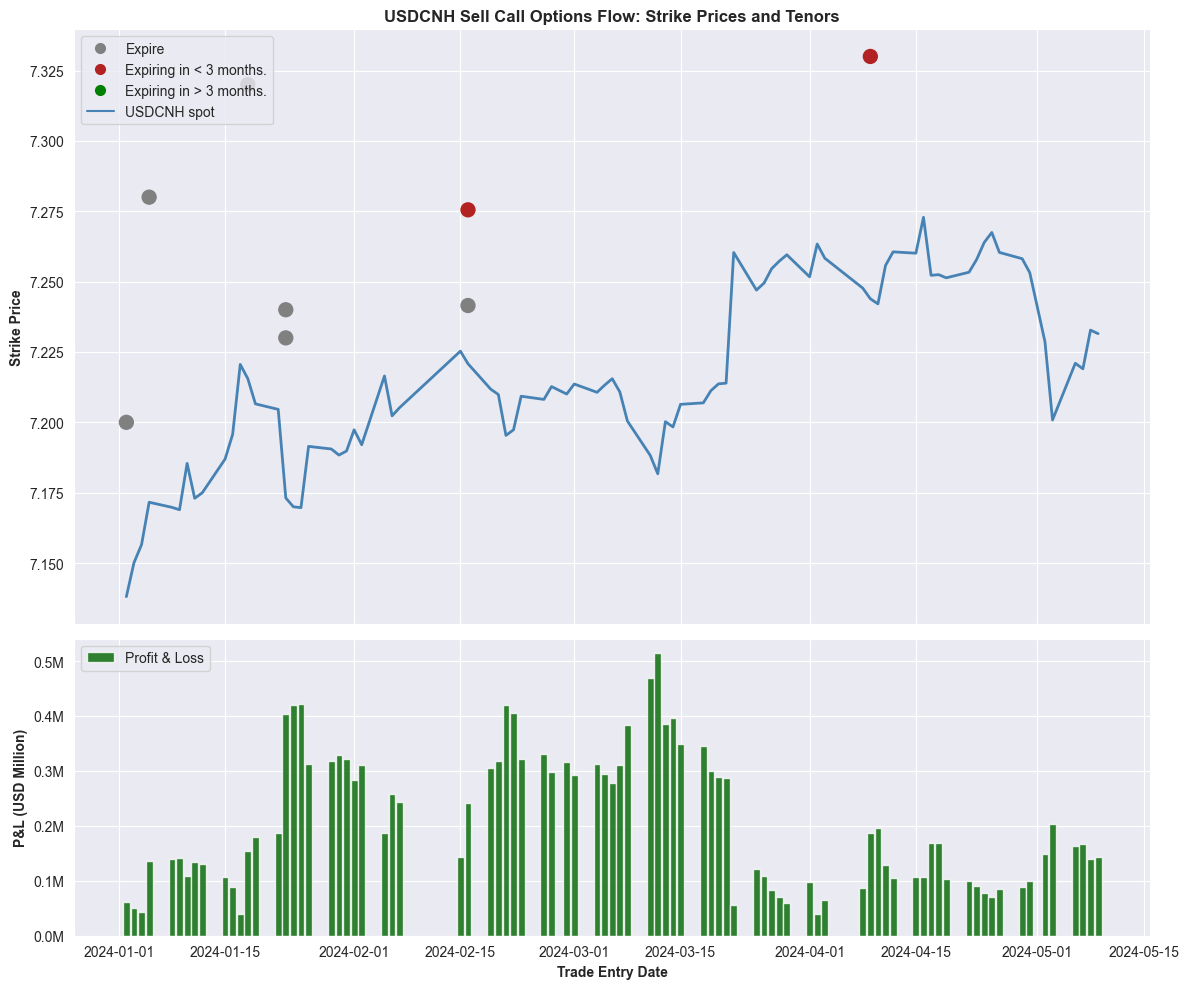

In [1259]:
# Ensure that the date column is converted to datetime and set it as index
USDCNH_spot['date'] = pd.to_datetime(USDCNH_spot['date'])
USDCNH_spot.set_index('date', inplace=True)

# Convert the date column to datetime for USDCNH_spot_call if not already done
USDCNH_spot_call['date'] = pd.to_datetime(USDCNH_spot_call['date'])

# Create subplots with different heights for ax1 and ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

sns.set_style("darkgrid")

# Plot the USDCNH spot rate on ax1
ax1.plot(USDCNH_spot.index, USDCNH_spot['spot_rate'], color='steelblue', linewidth=2, label='USDCNH spot')

plot_size = 0.0001

# Scatter plots for different option data with varying marker sizes on ax1
ax1.scatter(USDCNH_opt_data_call_due["Trade entry"], USDCNH_opt_data_call_due["Strike"], 
            s=USDCNH_opt_data_call_due["Notional"] * plot_size, c='grey', label='Expire')
ax1.scatter(USDCNH_opt_data_call_less_3months["Trade entry"], USDCNH_opt_data_call_less_3months["Strike"], 
            s=USDCNH_opt_data_call_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')
ax1.scatter(USDCNH_opt_data_call_more_3months["Trade entry"], USDCNH_opt_data_call_more_3months["Strike"], 
            s=USDCNH_opt_data_call_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')

# Labels and titles for ax1
ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDCNH Sell Call Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")
ax1.grid(True)

# Set up the legend for ax1
handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7  # Adjust the size to your preference
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  # 新增一個藍色折線圖例
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDCNH spot'],  # 新增"USDCNH spot"文字
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDCNH_spot_call['P&L']]

# Plot the bar chart for Profit & Loss on ax2 using USDCNH_spot_call's date
ax2.bar(USDCNH_spot_call['date'], USDCNH_spot_call['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M'))  # Set y-axis ticks formatter to millions
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

# Adjust the right y-axis scale for ax2
right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])

# Add a legend to the second subplot
ax2.legend(loc='upper left')

# Adjust layout for clarity
fig.tight_layout()
plt.show()


In [1260]:
# Calculate option P&L
USDCNH_opt_data_put_data = USDCNH_spot.copy()
USDCNH_opt_data_put_data = USDCNH_spot.copy().reset_index()
PL_list = []

for _, row in USDCNH_opt_data_put_data.iterrows():
    current_date = row['date']
    spot_rate = row['spot_rate']
    PL = 0

    active_options = USDCNH_opt_data_put[
        (USDCNH_opt_data_put['Trade entry'] <= current_date) &
        (USDCNH_opt_data_put['FX value date'] >= current_date)
    ]

    for _, opt_row in active_options.iterrows():
        strike = opt_row['Strike']
        notional = opt_row['Notional']
        PL += (spot_rate - strike) * (notional * spot_rate) / spot_rate

    PL_list.append(PL)

USDCNH_spot_put = USDCNH_spot.copy()
USDCNH_spot_put['P&L'] = PL_list
USDCNH_spot_put = USDCNH_spot_put.copy().reset_index()


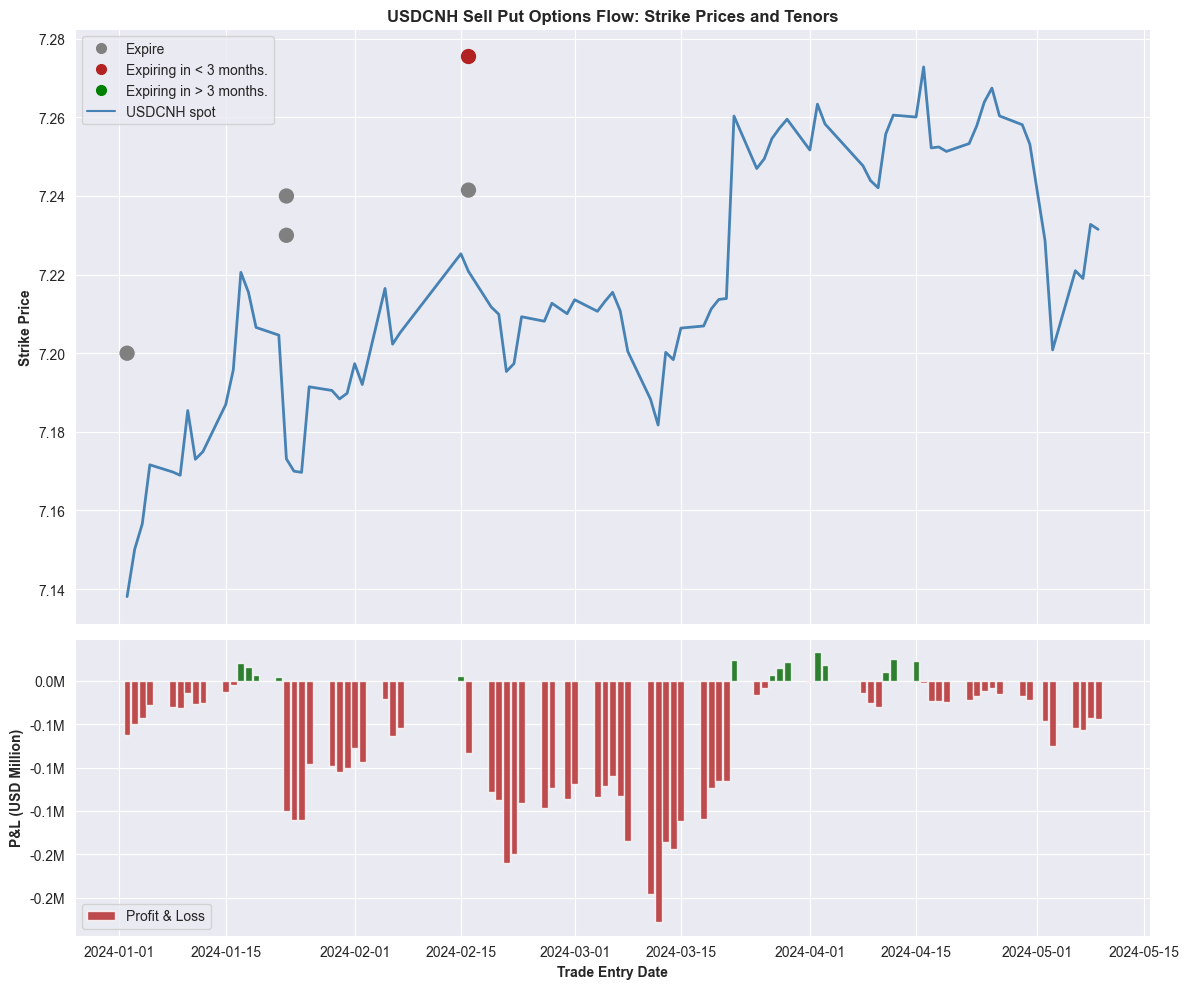

In [1261]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
sns.set_style("darkgrid")
ax1.plot(USDCNH_spot.index, USDCNH_spot['spot_rate'], color='steelblue', linewidth=2, label='USDCNH spot')

plot_size = 0.0001
ax1.scatter(USDCNH_opt_data_put_due["Trade entry"], USDCNH_opt_data_put_due["Strike"], 
            s=USDCNH_opt_data_put_due["Notional"] * plot_size, c='grey', label='Expire')  # 修改為 put 選擇權相關的資料框
ax1.scatter(USDCNH_opt_data_put_less_3months["Trade entry"], USDCNH_opt_data_put_less_3months["Strike"], 
            s=USDCNH_opt_data_put_less_3months["Notional"] * plot_size, c='firebrick', label='Expiring in < 3 months.')  # 修改為 put 選擇權相關的資料框
ax1.scatter(USDCNH_opt_data_put_more_3months["Trade entry"], USDCNH_opt_data_put_more_3months["Strike"], 
            s=USDCNH_opt_data_put_more_3months["Notional"] * plot_size, c='green', label='Expiring in > 3 months.')  # 修改為 put 選擇權相關的資料框

ax1.set_ylabel('Strike Price', fontweight="bold")
ax1.set_title('USDCNH Sell Put Options Flow: Strike Prices and Tenors', fontsize=12, fontweight="bold")  # 修改標題
ax1.grid(True)

handles, labels = ax1.get_legend_handles_labels()
uniform_marker_size = 7 
ax1.legend([plt.Line2D([0], [0], linestyle='None', marker='o', color='grey', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='firebrick', markersize=uniform_marker_size),
            plt.Line2D([0], [0], linestyle='None', marker='o', color='green', markersize=uniform_marker_size),
            plt.Line2D([0], [0], color='steelblue')],  
           ['Expire', 'Expiring in < 3 months.', 'Expiring in > 3 months.', 'USDCNH spot'],  
           loc='upper left')

# Determine the colors based on whether P&L is positive or negative
colors = ['darkgreen' if value > 0 else 'firebrick' for value in USDCNH_spot_put['P&L']]  # 修改為 put 選擇權相關的資料框

ax2.bar(USDCNH_spot_put['date'], USDCNH_spot_put['P&L'], color=colors, width=0.9, alpha=0.8, label='Profit & Loss')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1e6:.1f}M')) 
ax2.set_xlabel('Trade Entry Date', fontweight="bold")
ax2.set_ylabel('P&L (USD Million)', fontweight="bold")
ax2.grid(True)

right_max = ax2.get_ylim()[1]
ax2.set_ylim([ax2.get_ylim()[0], right_max])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.show()


In [1262]:
usdtwd_data = opt_data[opt_data['Currency pair'] == 'USD/TWD']
usdjpy_data = opt_data[opt_data['Currency pair'] == 'USD/JPY']
eurusd_data = opt_data[opt_data['Currency pair'] == 'EUR/USD']
usdcnh_data = opt_data[opt_data['Currency pair'] == 'USD/CNH']

# Group by Customer and sum Notional for each Currency pair
usdtwd_grouped = usdtwd_data.groupby('cCUST_LegalName')['Notional'].sum().nlargest(10)
usdjpy_grouped = usdjpy_data.groupby('cCUST_LegalName')['Notional'].sum().nlargest(10)
eurusd_grouped = eurusd_data.groupby('cCUST_LegalName')['Notional'].sum().nlargest(10)
usdcnh_grouped = usdcnh_data.groupby('cCUST_LegalName')['Notional'].sum().nlargest(10)

usdtwd_grouped = pd.DataFrame(usdtwd_grouped)
usdjpy_grouped = pd.DataFrame(usdjpy_grouped)
eurusd_grouped = pd.DataFrame(eurusd_grouped)
usdcnh_grouped = pd.DataFrame(usdcnh_grouped)

In [1263]:
print("Top 10 clients by Notional for USD/TWD:")
usdtwd_grouped

Top 10 clients by Notional for USD/TWD:


,Notional
cCUST_LegalName,
大地興機器廠股份有限公司,58000000.0
光陽工業股份有限公司,13000000.0
貫興實業有限公司,12000000.0
豐群水產股份有限公司,10000000.0
英業達股份有限公司,9000000.0
信成行國際股份有限公司,5000000.0
三星科技股份有限公司,4750000.0
醫樺儀器有限公司,4700000.0
台灣晶技股份有限公司,4000000.0


In [1264]:
print("\nTop 10 clients by Notional for USD/JPY:")
usdjpy_grouped


Top 10 clients by Notional for USD/JPY:


,Notional
cCUST_LegalName,
台灣晶技股份有限公司,18000000.0
貫興實業有限公司,12750000.0
YUHON ENTERPRISE CORPORATION,7000000.0
PROFIT EXPRESS LIMITED,6900000.0
SKYMAX INTERNATIONAL CORP.,5000000.0
富綱實業股份有限公司,5000000.0
衛麗生實業股份有限公司,3900000.0
泓翔企業股份有限公司,2100000.0
"GREAT BENEFIT ENTERPRISE CO.,LTD",2000000.0


In [1265]:
print("\nTop 10 clients by Notional for EUR/USD:")
eurusd_grouped


Top 10 clients by Notional for EUR/USD:


,Notional
cCUST_LegalName,
SKYMAX INTERNATIONAL CORP.,25000000.0
MEGA NOVA INTERNATIONAL CORP,6000000.0
"CENTRAL VALVE CO.,LTD.",4000000.0
HSY CORPORATION LTD.,1000000.0
原動力自行車科技股份有限公司,500000.0


In [1266]:
print("\nTop 10 clients by Notional for USD/CNH:")
usdcnh_grouped


Top 10 clients by Notional for USD/CNH:


,Notional
cCUST_LegalName,
台灣晶技股份有限公司,10000000.0
SANTERLON INTERNATIONAL INC.,3000000.0
